In [1]:
import pygly2
from pygly2.io import glycoct
from pygly2.structure import (glycan, monosaccharide, substituent)

from pygly2 import plot
from pygly2.algorithms import subtree_search, database

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = 10, 8
from IPython.display import display, Image

## The Database Module

When we are interested in finding out what kinds of structures we might have in some unknown data, the first place we start is with "what do we think is possible?". This usually involves reading articles and hand-tuning a hypothesis to test. Alternatively, we can throw everything possible at the data and to see what sticks. In both of these cases we need to actually have a collection of structures that we can curate, annotate, and test.

The `database` module is here for provide a convenient and performant container for glycan structures, implemented on top of `sqlite3`. We've pre-package all of the definite structures in Glycome-DB, which you can download from PyPI or with the `pygly2.io.glycomedb` module, directly from [www.glycome-db.org](www.glycome-db.org).

Let's assume you've downloaded the database and it's in your current directory

In [2]:
glycomedb = database.dbopen("./glycomedb.db")
glycomedb

<RecordDatabase 28431 records>

Depending upon the version of `pygly2` you have, you may see fewer or more records as the library matures to handle more irregular structures. As of this moment, it doesn't attempt to represent structures with `REP` repeating elements or `UND` undefined subgraphs. This version was created as strictly as possible, so if we didn't represent it exactly, it wasn't included.

If you're familiar with SQL, this block of code explains the structure of the table as it is stored on disk in an SQLite database file. 

```sql
CREATE TABLE GlycanRecord(
    glycan_id INTEGER UNIQUE PRIMARY KEY NOT NULL, 
    mass float NOT NULL,
    structure TEXT NOT NULL, glycoct TEXT, /* Special */
    is_n_glycan BOOLEAN,
    composition VARCHAR(120)
);
```

The `structure` field is special, it contains all of the data about this record as a `Python` object, [pickled](https://docs.python.org/2/library/pickle.html) and serialized in the database. This means we can add anything we like to the Python object without needing to map it to a column in the database. However, if we can map something to a column in the table, we can search against it quickly.

### Searching the Database

The database object, `glycomedb` here, wraps an SQLite connection. In other words, it can do everything [sqlite3.Connection](https://docs.python.org/2/library/sqlite3.html?highlight=sqlite3#connection-objects) does, execute SQL commands to quickly search, filter, add, or remove records.

Here we'll search for every entry in the database that has the N-Glycan Core motif, which has been mapped to the `is_n_glycan` column.

In [20]:
import time
start = time.time()
i = len(list(glycomedb.from_sql(glycomedb.execute("SELECT * FROM GlycanRecord WHERE is_n_glycan=1;"))))
end = time.time()
i, end - start

(5443, 33.504000186920166)

It took 33 seconds to search nearly 28,000 records and extract those that match the criterion. This is good if we routinely want to select something depending upon whether or not it's an N-Glycan. 

Some structures in `Glycome-DB` are reduced, meaning they have an alditol group on their reducing end. This isn't mapped to the table schema above, but we can still search the database using pure `Python`. The database class, `RecordDatabase`, will by default iterate over all of the records in the `GlycanRecord` table in the order they were inserted. Each record is an object of the class `GlycanRecord`, which holds a `Glycan` object in its `structure` attribute, and lots of other annotations to be shown later.

In [21]:
start = time.time()
i = 0
for rec in glycomedb:
    if rec.structure.reducing_end is not None:
        i += 1
end = time.time()
i, end - start

(3040, 77.43799996376038)

Looping over all 28,000 records in Python was over 2x slower, over a minute to run. Though this comparison is not totally fair, it is a good argument for using SQL to search. The slowest step is constructing the object from the database. This keeps only one object in memory time.

We can also access records by their database ID number, if we know it. For example [Glycome-DB:183](http://www.glycome-db.org/database/showStructure.action?glycomeId=183)

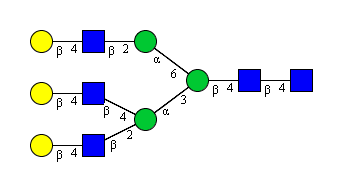

In [5]:
import urllib2
Image(urllib2.urlopen("http://www.glycome-db.org/getSugarImage.action?id=183&type=cfg").read())

<GlycanRecord 183 2005.72436779>
RES
1b:b-dglc-HEX-1:5
2s:n-acetyl
3b:b-dglc-HEX-1:5
4s:n-acetyl
5b:b-dman-HEX-1:5
6b:a-dman-HEX-1:5
7b:b-dglc-HEX-1:5
8s:n-acetyl
9b:b-dgal-HEX-1:5
10b:b-dglc-HEX-1:5
11s:n-acetyl
12b:b-dgal-HEX-1:5
13b:a-dman-HEX-1:5
14b:b-dglc-HEX-1:5
15s:n-acetyl
16b:b-dgal-HEX-1:5
LIN
1:1d(2+1)2n
2:1o(4+1)3d
3:3d(2+1)4n
4:3o(4+1)5d
5:5o(3+1)6d
6:5o(6+1)13d
7:6o(2+1)10d
8:6o(4+1)7d
9:7d(2+1)8n
10:7o(4+1)9d
11:10d(2+1)11n
12:10o(4+1)12d
13:13o(2+1)14d
14:14d(2+1)15n
15:14o(4+1)16d

[<Taxon tax_id=9031 name=None entries=None>, <Taxon tax_id=9913 name=None entries=None>, <Taxon tax_id=11033 name=None entries=None>, <Taxon tax_id=9606 name=None entries=None>, <Taxon tax_id=9940 name=None entries=None>]


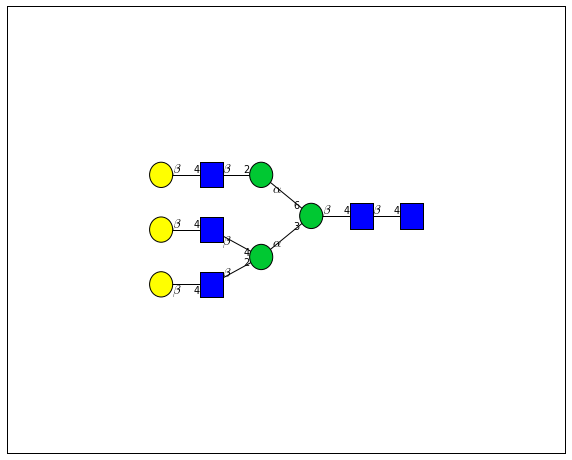

In [6]:
record183 = glycomedb[183]
draw_tree, axes = plot.plot(record183, label=True, scale=0.15)

print record183
print record183.taxa

If you look at the picture, this is the same structure, but you also see it's `GlycoCT`representation when the object is printed out. Another of the facets of the `GlycanRecord` class is the storage for provenance information, like species the structure is associated with. The data-dump from `Glycome-DB` only contains taxon id numbers. You might recognize 9606 as Human, but the others are probably unfamiliar. 

It's outside the scope of this project to automatically include that sort of information, however the [taxonomylite](http://pythonhosted.org//taxonomylite/) package (disclaimer: I am the an author and the maintainer) does this job nicely. If we also have downloaded or built a `Taxonomy` database from `taxonomylite`, we can put names to those numbers:

In [7]:
import taxonomylite
taxa_db = taxonomylite.Taxonomy("taxonomy.db")
[(taxa_db.tid_to_name(taxon.tax_id), taxon.tax_id) for taxon in record183.taxa]

[(u'Gallus gallus', '9031'),
 (u'Bos taurus', '9913'),
 (u'Semliki Forest virus', '11033'),
 (u'Homo sapiens', '9606'),
 (u'Ovis aries', '9940')]

We could also mix the `Taxonomy` database directly into `glycomedb`, but that would quadruple the file size.

Because `GlycanRecord` objects are *just* `Python` objects, we can add new attributes to them and save them to the database for later.

In [8]:
record183.fragments = list(record183.structure.fragments("AXBYCZ"))
print len(record183.fragments)
record183.update()

220


Here we've added a new attribute, and called the record's `update()` method, which writes its current state to the database. If we go load the record from disk again, the new attribute should still be present.

In [9]:
len(glycomedb[183].fragments)

220

## An Application
What if we wanted to do something like build a database of human N-Glycan structures? We could do it easily in memory by doing something like this:

In [45]:
human_n_glycans = []
for row in glycomedb.execute("SELECT * FROM GlycanRecord WHERE is_n_glycan=1;"):
    record = glycomedb.record_type.from_sql(row, glycomedb) # Convert each raw row into GlycanRecord instance
    for taxon in record.taxa:
        if taxon.tax_id == "9606":
            human_n_glycans.append(record)
            break
print len(human_n_glycans)

888


   1. This first reduces the number of records to search in `Python` by using SQL to quickly pull out all N-Glycans, then convert those rows of the database to python objects using `from_sql()`.
   2. For each record retrieved, test if any of its taxa are Human. If so, add them to the list and move on to the next record

So we have 888 records in memory. While we're at it, we'll say the experiment we have in mind will be on permethylated, reduced glycans, so let's reduce them and derivatize them.

In [46]:
from pygly2.composition.composition_transform import derivatize

for record in human_n_glycans:
    record.structure.set_reducing_end(True)
    derivatize(record.structure, "methyl")


The records are still in memory. We can write them to disk in `glycomedb`, but that's probably not what we want, since we've transformed these structures and we want to keep our reference database clean. We can create a new database object to save them in easily though. 

First, let's remember that we really wanted to be able to tell easily if a structure was "high mannose" or not. We'll say something is "high mannose" if it has more than 5 Hexose in its composition. This classification may be dubious, but for some applications, it may be valid. We could make it a new attribute on the object, but that would probably take too long to filter by. Let's try adding it to the new database's table schema.

To do that, we first need to create a new record type, derived from `GlycanRecord`

In [47]:
def is_high_mannose(record):
    return int(record.monosaccharides['Hex'] > 4)

@database.column_data("is_high_mannose", "BOOLEAN NOT NULL", is_high_mannose)
class IsHighMannoseGlycanRecord(database.GlycanRecord):
    pass

experiment_db = database.dbopen("experiment.db", record_type=IsHighMannoseGlycanRecord, flag='w')
experiment_db.load_data(human_n_glycans, set_id=False)
experiment_db.apply_indices()
print len(experiment_db)


888


This new class is a straight copy of the `GlycanRecord` class's internal logic, except that it now includes a new column in the mapped SQL schema. The column, `is_high_mannose`, is declared as a `BOOLEAN` data type, and it is mapped by this function:

```python
def is_high_mannose(record):
    return int(record.monosaccharides['Hex'] > 4)
```

You might ask why the result is cast to an `int` instead of left as `True` or `False`. The reason is that SQLite doesn't have a key word literal for boolean values, and just treates 0 as `False` and any other number as `True`.

The resulting table schema looks like:

```sql
/* Generaged by calling '\n'.join(IsHighMannoseGlycanRecord.sql_schema()) */
CREATE TABLE GlycanRecord(
    glycan_id INTEGER UNIQUE PRIMARY KEY NOT NULL,
    mass float NOT NULL,
    structure TEXT NOT NULL, glycoct TEXT,
    is_high_mannose BOOLEAN, /* Newly created */
    is_n_glycan BOOLEAN,
    composition VARCHAR(120));
```

Notice the new column added. We can now quickly filter structures by the `is_high_manose` criterion. After loading the data, we call `apply_indices` to index the database by mass. We could add more indices if we wished to by executing raw SQL.

In [16]:
start = time.time()
res = len(list(experiment_db.from_sql(experiment_db.execute("SELECT * FROM GlycanRecord WHERE is_high_mannose=1;"))))
res, time.time() - start

(595, 10.51199984550476)

In [14]:
i = 0
start = time.time()
for record in experiment_db:
    if is_high_mannose(record):
        i += 1
i, time.time() - start

(595, 105.88299989700317)

In [28]:
start = time.time()
i = 0
for record in human_n_glycans:
    if is_high_mannose(record):
        i += 1
i, time.time() - start 

(595, 108.72199988365173)

Using the precomputed SQL field, we can find and extract all 595 records in 10 seconds. Doing it with a database iterator takes 10 times longer. This is because it needs to construct every record and executes the test over and over again.

## Mass Searching
If we know we're looking for all the entries in our database which are near a particular mass value, it's straight-forward to query

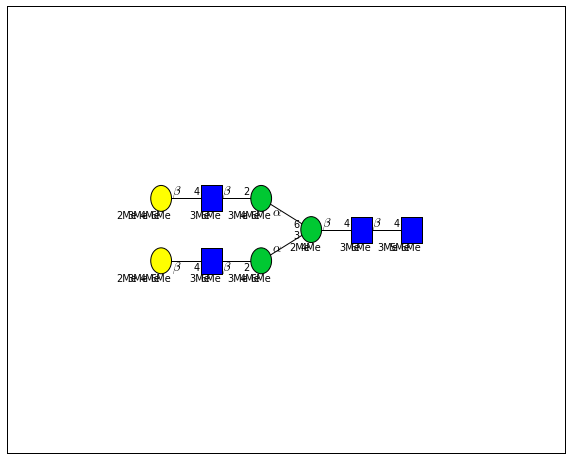

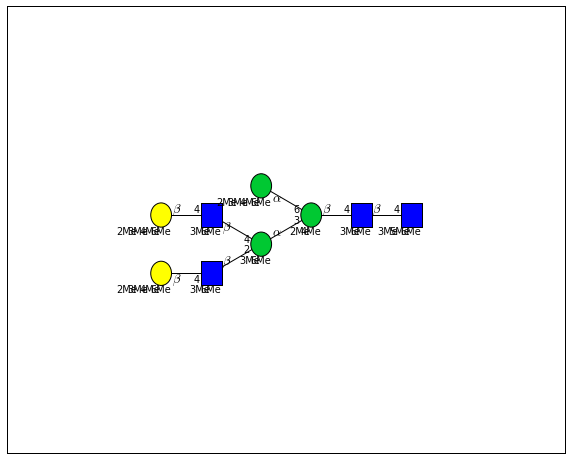

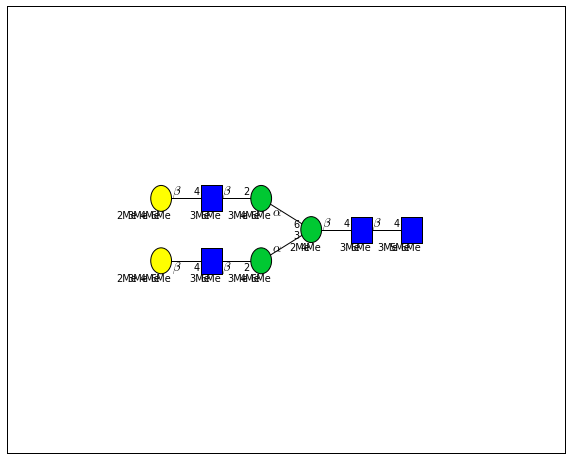

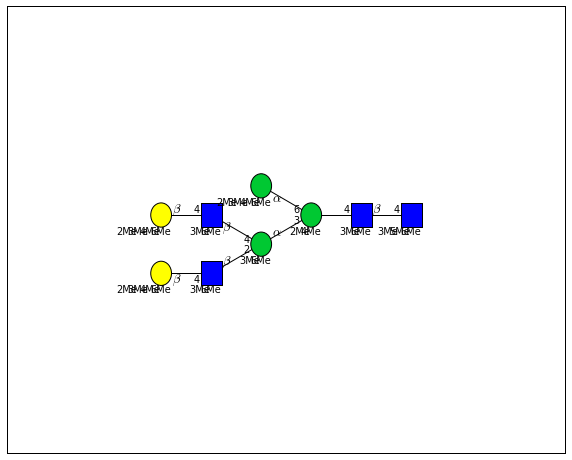

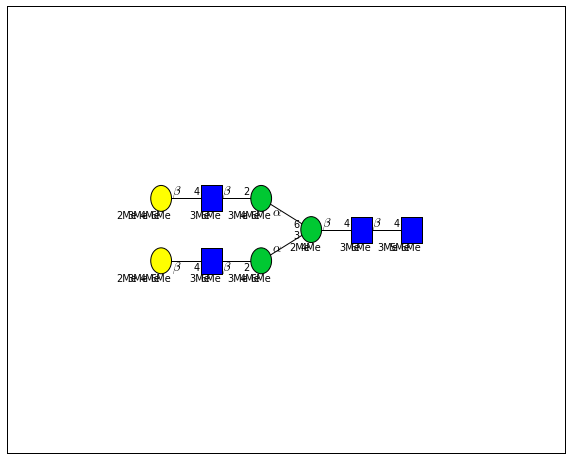

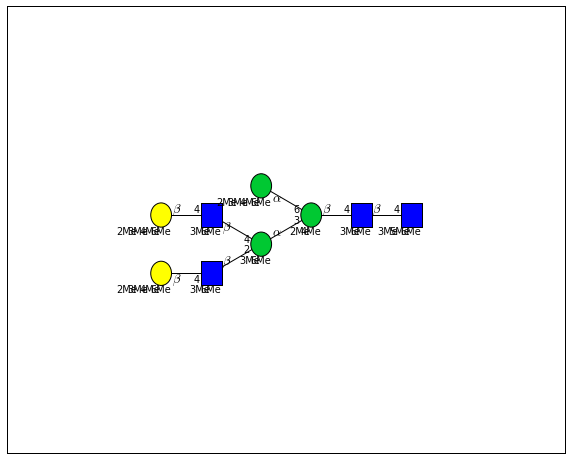

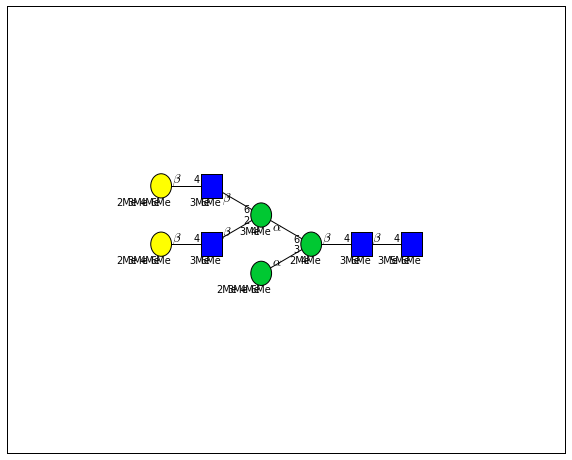

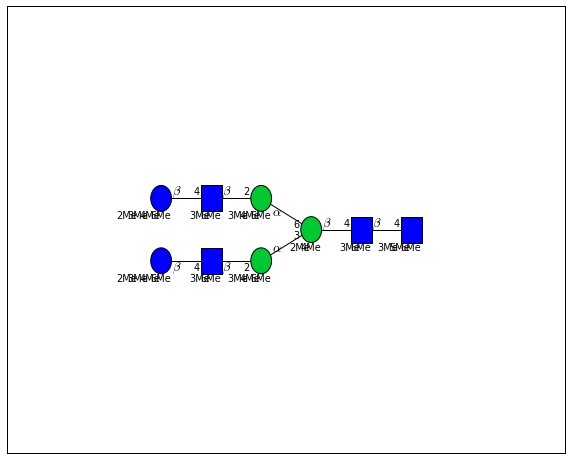

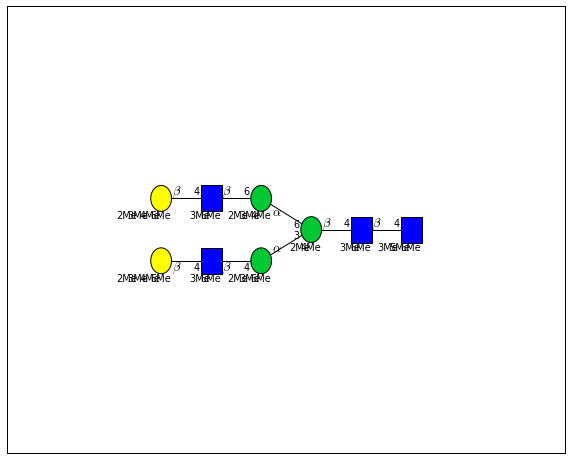

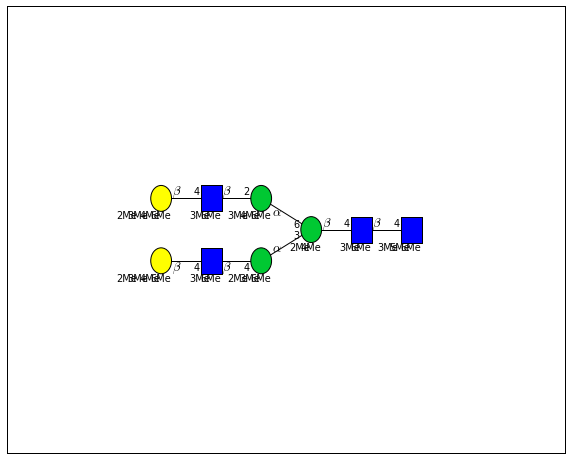

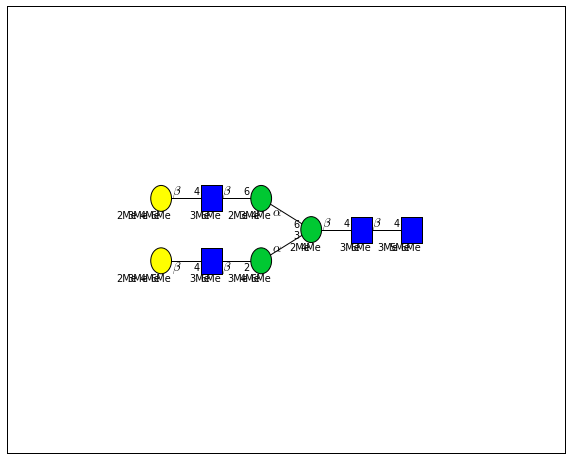

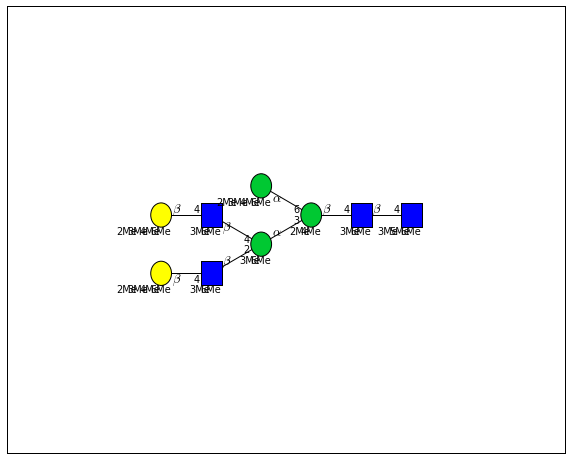

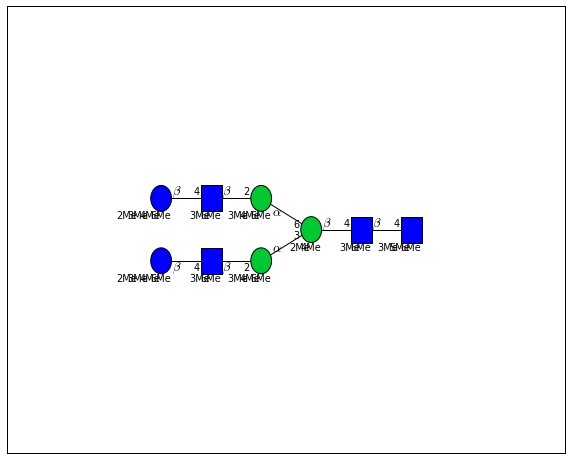

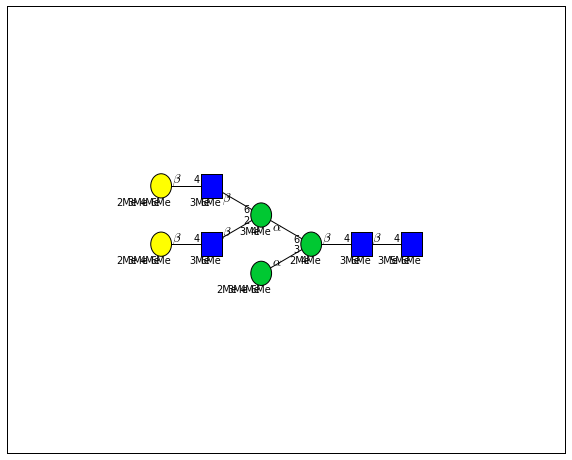

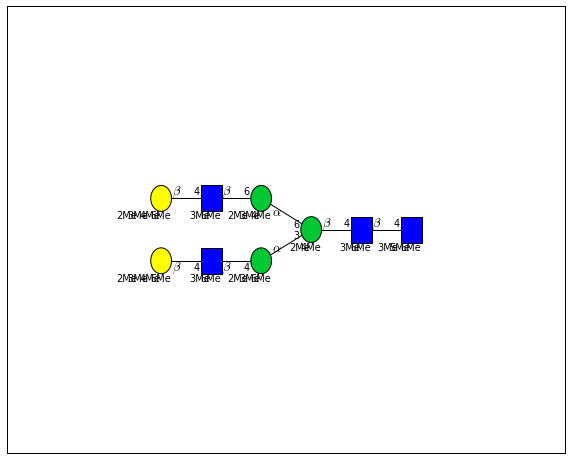

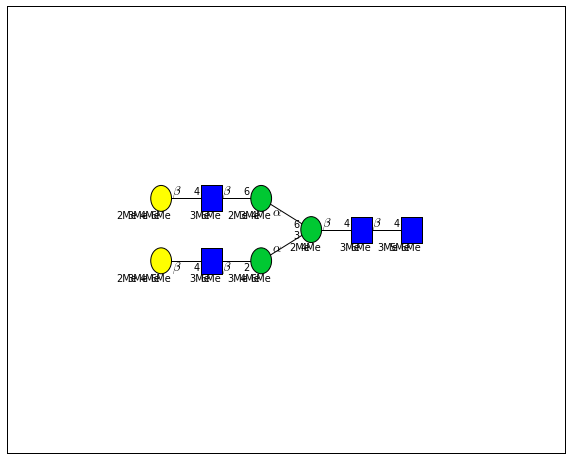

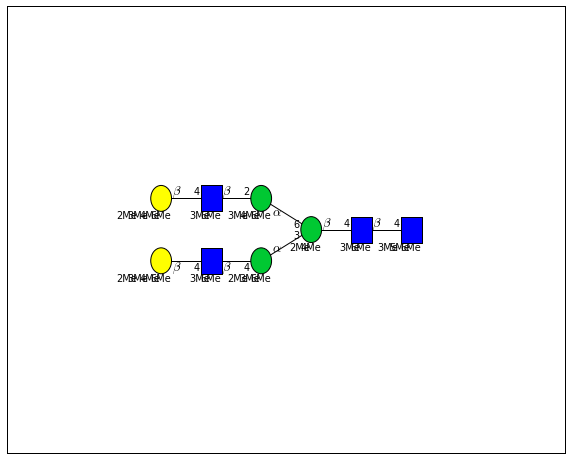

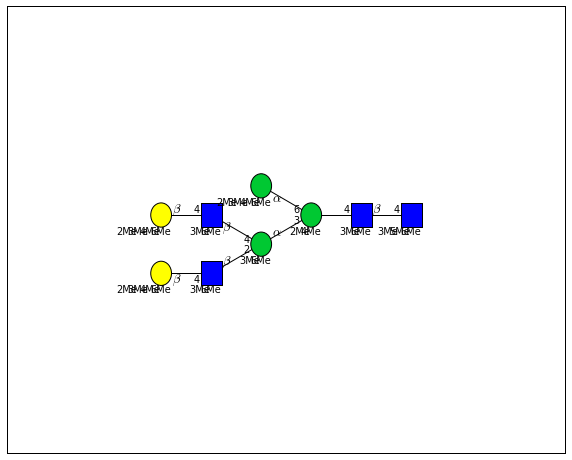

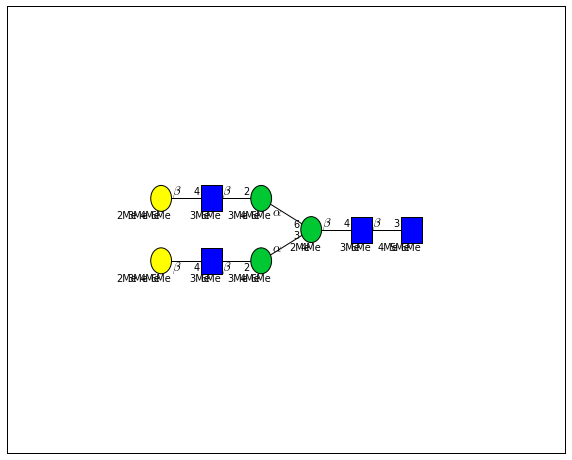

In [72]:
for match in (experiment_db.ppm_match_tolerance_search(2063.0773, 1e-5)):
    plot.plot(match, label=True, scale=0.135)

It looks like there are several linkage variants of the many similar topologies and composition in the database that match that mass. 

If we had tandem mass spectra with the critical fragment, say a cross ring cleavage along the central Mannose of the N-Glycan Core motif, we could discern which broad topology we had. With MS<sup>n</sup>, determining linkage would be doable too. 